<a href="https://colab.research.google.com/github/MaslovAleksey/Image-style-transfer/blob/main/Image_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Перенос стиля изображения**

## **1.) Техническое описание**

* ### **Постановка задачи:**
> #### Сформировать алгоритм, выполняющий перенос стиля с одного изображения на другое.

---

* ### **Используемые библиотеки и модули:**
> #### torch, torchvision, scipy, math, numpy, Image, matplotlib, os, colab,Variable, PIL.

---

* ### **Данные для обучения:**
> #### 1.   Данные представляют собой набор из нескольких исходных изображений (под перенос стиля) и несколько изображений различных стилей;
> #### 2.   Изображения имеют 3-х канальную структуру (RGB);
> #### 3.   Целевое изображение (target image) инициализируется начальным изображением (content image);
> #### 4.   Изображения проходят предварительную нормализацию и редактирование размеров.

---

* ### **Отличительные черты архитектуры нейронной сети:**
> #### 1.   Нейронная сеть реализуется в виде класса *PretrainedModel*, который наследует класс *nn.Module*;
> #### 2.   Объекты класса *PretrainedModel* имеют в своём составе атрибут, содержащий предобученную сеть *VGG19*;
> #### 3.   В методе *forward()* реализован процесс предсказания нейронной сети, в котором формируется список наборов признаков, полученных с необходимых слоёв *VGG19*, выбранных пользователем;
> #### 4.   В предобученной модели *VGG19* слои *max_pooling2d* будут заменены на *average_pooling2d* согласно рекомендациям авторов научной статьи.

---

* ### **Особенности реализации алгоритма:**
> #### 1.   Алгоритм реализован на языке *torch*;
> #### 1.   При реализации алгоритма переноса стиля будем использовать предобученную сеть VGG19, извлекающую особенности изображений (features);
> #### 2.   Вычисления выполняются с использованием *CUDA* (*torch.device("cuda"*));
> #### 3.   Для сохранения информации о конфигурации трансформации используется класс *SimpleNamespace()*, позволяющий добавлять и удалять атрибуты;
> #### 4.   В процессе обратного распространения ошибки меняться будет целевое изображение, а не веса нейронной сети.
> #### 5.   Ошибка обучения складывается из двух составляющих: *content_loss* и *style_loss*. Соответствие исходному изображению (*content_loss*) - *nn.MSELoss()*. Ошибка переноса стиля (*style_loss*) формируется на основании вычисления *nn.MSELoss()* между матрицами Грама.


## **2.) Подготовка данных**

### **Подключение необходимых библиотек**

In [ ]:
import numpy as np
import os
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from types import SimpleNamespace # подкласс object, позволяющий добавлять и удалять атрибуты
from google.colab import drive

import torch
import torch.nn as nn # необходимые слои
import torch.utils.data as data # инструменты для работы с загрузчиком данных
from torch.autograd import Variable # инструменты для автоматического дифференцирования
from torchvision import models # предобученные модели
import torchvision.transforms as transforms
import torchvision.datasets as dsets # инструменты для работы с классом Dataset

### **Загрузка данных с Google диска**

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/UAI/24.) Writing neural networks with a library Pytorch (Part 2)/Data/content.zip"
!unzip -q "/content/drive/MyDrive/Colab Notebooks/UAI/24.) Writing neural networks with a library Pytorch (Part 2)/Data/style.zip"

### **Глобальные переменные**

In [ ]:
# Путь к данным
content_pass = "/content/content"
style_pass = "/content/style"

num_chnls = 3

# Списки названий изображений
content_names = [name.replace(".jpg", "") for name in os.listdir(content_pass)]
style_names = [name.replace(".jpg", "") for name in os.listdir(style_pass)]

# Количество изображений для обработки
num_content = len(content_names)
num_style = len(style_names)

num_features_vgg19 = len(models.vgg19().features) # Число наборов карт признаков сети vgg19

# Устройство для выполнения вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Параметры трансформации изображений
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inverse_mean = [-mean[i] / std[i] for i in range(len(mean))]
inverse_std = [1/std[i] for i in range(len(std))]

# Методы трансформации изображений
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = mean,
                                                                            std = std)])
inverse_transform = transforms.Normalize(mean = inverse_mean, std = inverse_std)

### **Демонстрация данных**

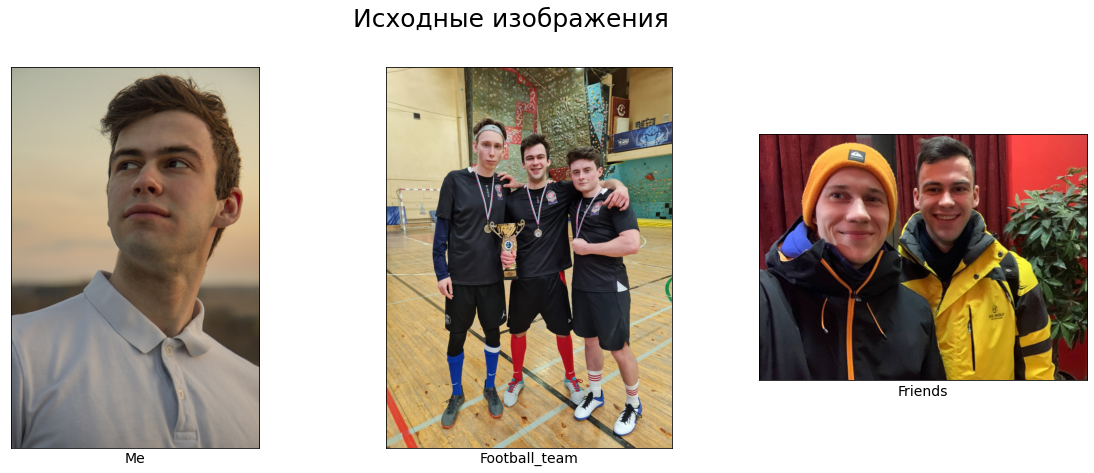

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
fig.suptitle("Исходные изображения", size=25, y=1)
for i in range (num_content):
  img_path = content_pass + '/' + content_names[i] + '.jpg'
  img = Image.open(img_path)
  # img = img.resize((img_height, img_width)) # форматиривание размеров изображения
  # img.thumbnail((img_height, img_width)) # ограничение размера изображения с сохранением пропорций
  ax[i].imshow(img)

  ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
  ax[i].get_yaxis().set_visible(False)
  ax[i].set_xlabel(content_names[i], size=14)

plt.show()

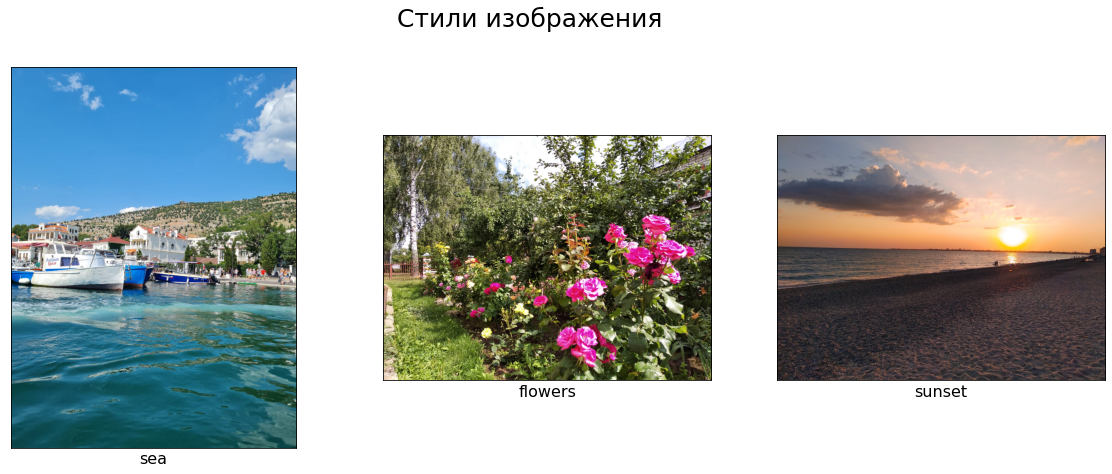

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
fig.suptitle("Стили изображения", size=25, y=1)
for i in range (num_style):
  img_path = style_pass + '/' + style_names[i] + '.jpg'
  img = Image.open(img_path)
  # img = img.resize((img_height, img_width)) # форматиривание размеров изображения
  # img.thumbnail((img_height, img_width)) # ограничение размера изображения с сохранением пропорций
  ax[i].imshow(img)

  ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
  ax[i].get_yaxis().set_visible(False)
  ax[i].set_xlabel(style_names[i], size=16)
  
plt.show()

## **3.) Необходимые функции и классы**

### **Формирование SimpleNamespace**

In [ ]:
'''

Класс, используемый для сохранения информации о конфигурации трансформации,
позволяющий сохранять и добавлять атрибуты

'''

def create_config():
  config = SimpleNamespace()
  print(f"Варианты основного изображения - {content_names}")
  config.content = input("Выберете основное изображение - ")
  print(f"\nВарианты стиля изображения - {style_names}")
  config.style = input("Выберете стиль изображения - ")
  config.steps = int(input("\nОбщее число шагов - "))
  config.step_write = int(input("Периодичность выведения ошибки - "))
  config.height = int(input("Высота изображения - "))
  config.width = int(input("Ширина изображения - "))
  config.content_weight = int(input("Степень сохранения черт исходного изображения [1;10] - "))
  config.style_weight = int(input("Степень воссоздания стиля [1;10] - "))
  config.learning_rate = float(input("Шаг обучения - "))

  return config

### **Загрузка изображения**

In [ ]:
def load_img(img_path=None, img_height = None, img_width = None, transform=None, device = None, target_random = False):
  # Формирование изображения для оптимизации
  if target_random:
    img = np.random.sample(size=(img_width, img_height, num_chnls)) # формирование изображения из случайного распределения
    img = np.array(ndimage.median_filter(img, [8,8,1]), dtype=np.float32)
  else:
    img = Image.open(img_path)

    # Преобразование размера
    if img_height and img_width:
      img = img.resize((img_width, img_height))
    elif img_height:
      img_width = np.array(img).shape[1]
      img = img.resize((img_width, img_height))
    elif img_width:
      img_height = np.array(img).shape[0]
      img = img.resize((img_width, img_height))
  
  # Применение трансформаций
  if transform:
    img = transform(img)
    

  # Размещение на устройстве
  if device:
    img =  img.to(device)

  img = img.unsqueeze(0) # добавление размерности в начало
  
  return img

### **Формирование данных**

In [ ]:
def create_data(need_content_pass, need_style_pass, target_random = False):
  content = load_img(img_path=need_content_pass, img_height = config.height, img_width = config.width, transform=transform, device=device) # исходное изображения
  style = load_img(img_path=need_style_pass, img_height = config.height, img_width = config.width, transform=transform, device=device) # стиль изображения

  # Итоговое изображение
  target = load_img(img_path=need_content_pass, img_height = config.height, img_width = config.width, transform=transform, device=device, target_random=target_random) # целевое изображение
  target = target.requires_grad_(True) # возможность вычисления частных производных

  return content, style, target 

### **Класс преобученной модели**

In [ ]:
'''

Класс, реализующий архитектуру нейронной сети.

1.) Наследует класс nn.Module;
2.) Объекты класса имеют в своём составе атрибут, содержащий предобученную сеть *VGG19*;
3.) В методе forward() реализован процесс предсказания нейронной сети, 
в котором формируется список наборов признаков, полученных с необходимых слоёв
VGG19, выбранных пользователем;
4.) В предобученной модели VGG19 слои *max_pooling2d* будут заменены
на *average_pooling2d* согласно рекомендациям авторов научной статьи.

'''

class PretrainedModel(nn.Module):
  def __init__(self, ind_layers, pool, device):
    super(PretrainedModel, self).__init__() # конструктор родительского класса
    self.ind_layers = ind_layers
    self.pool = pool
    self.vgg19 =  models.vgg19(pretrained=True).to(device)
  
    # max_pooling2D -> average_pooling2D
    if self.pool == "average":
      for i in range(len(self.vgg19.features)):
        if (type(self.vgg19.features[i]) == torch.nn.modules.pooling.MaxPool2d):
          self.vgg19.features[i] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
  
  # Извлечение необходимых наборов признаков
  def forward(self, x):
    need_features = [] # список извлечённых наборов признаков 
    predict = x
    for i in range(len(self.vgg19.features)): # прохождение по каждому слою vgg19
      predict = self.vgg19.features[i](predict) 
      if (i in self.ind_layers): # необходим ли данный набор признаков
        need_features.append(predict)
    
    return need_features

### **Создание модели**

In [ ]:
def create_pretrained_model(device):
  num_layers = int(input(f"Число наборов карт признаков модели VGG19 (не более {num_features_vgg19}) - "))
  ind_layers = [] # список индексов необходимых наборов

  for i in range(num_layers):
    ind = int(input(f"Индекс {i+1}-го набора - "))
    ind_layers.append(ind)
  
  pool = input("\nМетод уменьшения размерности (average/max) - ")
  
  pretrained_model = PretrainedModel(ind_layers, pool, device)

  return pretrained_model

### **Визуализация процесса обучения**

In [ ]:
def training_visual(content_losses, style_losses, total_losses):
  fig, ax = plt.subplots(figsize=(12,7))
  ax.set_title("Ошибка MSE в процессе обучения", size=16, pad=20)
  ax.plot(content_losses, label="ошибка соответствия исходному изображению")
  ax.plot(style_losses, label="ошибка переноса стиля")
  ax.plot(total_losses, label="суммарная ошибка")
  ax.set_xlabel("Число эпох", size=12)
  ax.set_ylabel("MSE", size=12)
  ax.legend(prop={"size":12})
  plt.show()

### **Осуществление переноса стиля**

In [ ]:
'''

Функция, осуществляющая перенос стиля изображения.

1.) Алгоритм реализован на языке torch;
2.) В процессе обратного распространения ошибки меняться будет целевое изображение, 
а не веса нейронной сети;
3.) Ошибка обучения складывается из 2-х составляющих: 
- соответствие исходному изображению (content_loss)
- ошибка переноса стиля (style_loss)
4.) Ошибка соответствия исходному изображению - nn.MSELoss()
5.) Ошибка переноса стиля формируется на основании вычисления nn.MSELoss() между
матрицами Грама. 
6.) Матрицы Грама получаются в результате матричного перемножения двумерной матрицы
признаков изображения и её транспонированной матрицы. Переход от трёх мерной 
матрицы признаков (ch, h, w) к двумерной (ch, h*w) обуславливается тем, 
что стиль изображения не должен быть привязан к конкретному местоположению 
на фотографии.
7.) В качестве оптимизатора используется torch.optim.Adam()

'''

def style_transfer(content, style, target, config, pretrained_model):
  # Установка режима предсказания
  model = pretrained_model.eval()

  # Инструменты обучения
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam([target], lr=config.learning_rate) # back propagation будет применяться только к target

  # Переменный для сохранения ошибкок
  content_losses = []
  style_losses = []
  total_losses = []

  for i in range(config.steps):
    # Извлечение необходимых карт признаков
    content_features = model(content)
    style_features = model(style)
    target_features = model(target)

    content_loss = 0
    style_loss = 0 

    # Анализ каждого набора признаков
    for f1, f2, f3 in zip(content_features, style_features, target_features):
      # Ошибка соответствия исходному изображению
      content_loss +=  criterion(f1, f3)

      # Формирование матриц Грама
      _, ch, h, w = f2.size()
      
      f2_tr = f2.reshape(ch, h*w).to(device) # изменение размерности
      f3_tr = f3.reshape(ch, h*w).to(device)

      f2_matr = torch.mm(f2_tr, f2_tr.t()) # матричное перемножение
      f3_matr = torch.mm(f3_tr, f3_tr.t())

      # Коэффициент потерь при переносе стиля
      coeff = 1 / (ch * h * w)

      # Ошибка переноса стиля
      style_loss += criterion(f2_matr, f3_matr) * coeff
    

    # Общая ошибка на основании весов предпочтений
    total_loss =  content_loss / config.content_weight**2 + style_loss / config.style_weight**2

    content_losses.append(content_loss.cpu().detach().data.numpy())
    style_losses.append(style_loss.cpu().detach().data.numpy())
    total_losses.append(total_loss.cpu().detach().data.numpy())

    # Обратное распространение ошибки
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if ((i+1) % config.step_write == 0):
      print(f"\nШаг № {i+1}/{config.steps}")
      print("Ошибка соответствия исходному изображению - {:.4f}, Ошибка переноса стиля - {:.4f}, суммарная ошибка - {:.4f}".format(content_loss.item(), style_loss.item(), total_loss.item()))
    
  training_visual(content_losses, style_losses, total_losses)

  return target

### **Визуализация результата**

In [ ]:
def result_visual(imgs, config, labels):

  n_imgs = len(imgs)

  fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(20,7))
  fig.suptitle("Демонстрация результата переноса стиля", y=0.95, size=25)

  for i in range(n_imgs):
    label = labels[i] # подпись для оси X

    if (label == "Изображение после переноса стиля"):
      img = inverse_transform(imgs[i]) # обратная трасформация
      img = img.cpu().detach().numpy()[0].transpose(1,2,0)
      img[img>1] = 1
      img[img<0] = 0
    else:
      img = Image.open(imgs[i])
      img = img.resize((config.width, config.height))

    ax[i].imshow(img)

    ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlabel(label, size=14)

  plt.show()

## **4.) Реализация процесса переноса стиля**

### **Конфигурация трансформации**

In [ ]:
config = create_config()

Варианты основного изображения - ['Me', 'Football_team', 'Friends']
Выберете основное изображение - Me

Варианты стиля изображения - ['sea', 'flowers', 'sunset']
Выберете стиль изображения - flowers

Общее число шагов - 1000
Периодичность выведения ошибки - 50
Высота изображения - 400
Ширина изображения - 400
Степень сохранения черт исходного изображения [1;10] - 1
Степень воссоздания стиля [1;10] - 10
Шаг обучения - 5e-3


### **Формирование данных для обучения**

In [ ]:
need_content_pass = content_pass + '/' + config.content + '.jpg'
need_style_pass = style_pass + '/' + config.style + '.jpg'

In [ ]:
content, style, target = create_data(need_content_pass, need_style_pass, target_random = False)

In [ ]:
print(f"Размер content - {content.shape}")
print(f"Размер style - {style.shape}")
print(f"Размер target - {target.shape}")

Размер content - torch.Size([1, 3, 400, 400])
Размер style - torch.Size([1, 3, 400, 400])
Размер target - torch.Size([1, 3, 400, 400])


### **Формирование преобученной модели (на основе VGG19)**

In [ ]:
pretrained_model = create_pretrained_model(device)

Число наборов карт признаков модели VGG19 (не более 37) - 10
Индекс 1-го набора - 0
Индекс 2-го набора - 4
Индекс 3-го набора - 9
Индекс 4-го набора - 12
Индекс 5-го набора - 18
Индекс 6-го набора - 21
Индекс 7-го набора - 27
Индекс 8-го набора - 30
Индекс 9-го набора - 32
Индекс 10-го набора - 36

Метод уменьшения размерности (average/max) - average


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
print("Архитектура преобученной модели:")
print(pretrained_model.vgg19.parameters)

Архитектура преобученной модели:
<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

### **Перенос стиля изображения**


Шаг № 50/1000
Ошибка соответствия исходному изображению - 1.0196, Ошибка переноса стиля - 977.6243, суммарная ошибка - 10.7959

Шаг № 100/1000
Ошибка соответствия исходному изображению - 2.5491, Ошибка переноса стиля - 401.0164, суммарная ошибка - 6.5592

Шаг № 150/1000
Ошибка соответствия исходному изображению - 3.2444, Ошибка переноса стиля - 190.0321, суммарная ошибка - 5.1448

Шаг № 200/1000
Ошибка соответствия исходному изображению - 3.3044, Ошибка переноса стиля - 143.8373, суммарная ошибка - 4.7427

Шаг № 250/1000
Ошибка соответствия исходному изображению - 3.2772, Ошибка переноса стиля - 126.8782, суммарная ошибка - 4.5460

Шаг № 300/1000
Ошибка соответствия исходному изображению - 3.2358, Ошибка переноса стиля - 119.0605, суммарная ошибка - 4.4264

Шаг № 350/1000
Ошибка соответствия исходному изображению - 3.1930, Ошибка переноса стиля - 115.0404, суммарная ошибка - 4.3434

Шаг № 400/1000
Ошибка соответствия исходному изображению - 3.1538, Ошибка переноса стиля - 112.7303, су

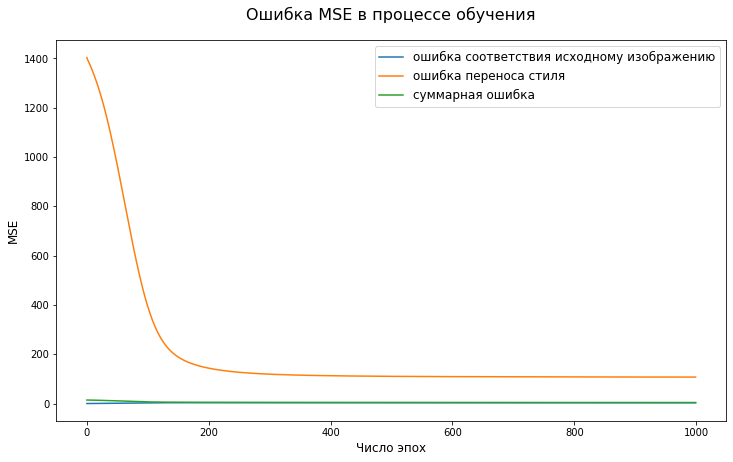

In [ ]:
style_img = style_transfer(content, style, target, config, pretrained_model)

### **Демонстрация результата**

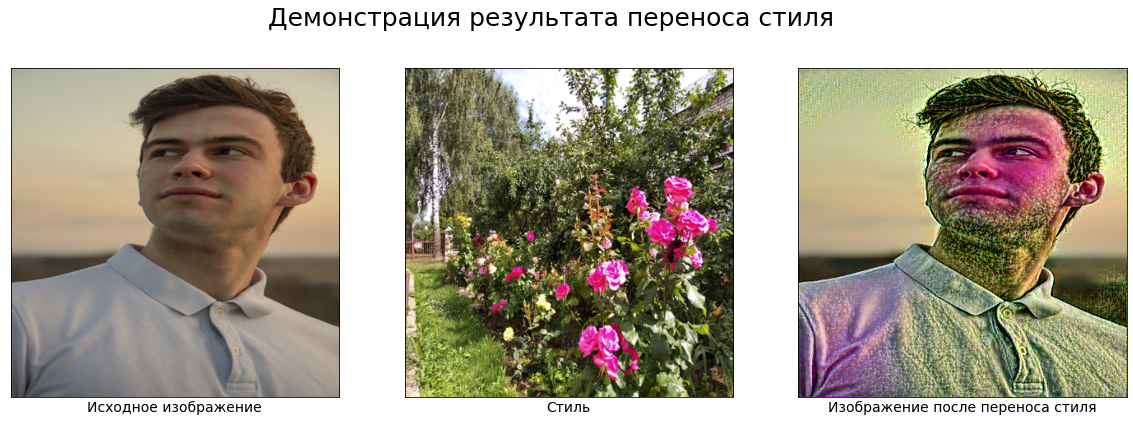

In [ ]:
labels = ["Исходное изображение", "Стиль", "Изображение после переноса стиля"]
imgs = [need_content_pass, need_style_pass, style_img]

result_visual(imgs, config, labels)

## **5.) Выводы по работе**

> #### 1.   При использовании функции "scipy.ndimage.median_filter(img, [8,8,1])", вектор "img" должен находиться на процессоре (cpu).
> #### 2.   При подаче в функцию "scipy.ndimage.median_filter(img, [8,8,1])" копии или ссылки на "content" мы получаем нелистовой тензор (non-leaf tensor), который невозможно оптимизировать. Для избежания данной ситуации нужно в качестве "img" использовать отдельно загруженное изображение
> #### 3.   При изменении формата размеров изображения методом "img.resize((img_width, img_height))" сначала подаётся ширина, а затем высота.
> #### 4.   Из графика обучения можно заметить, что изначально ошибка переноса стиля (*style_loss*) имеет весьма высокое значение, а затем на 1000 шагов её показания уменьшаются в 9 раз. Это свидетельстует об успешном переносе стиля изображения.
> #### 5.   Ошибка соответсвия исходному изображению колеблется на протяжении всего обучения в довольно невысоком диапазоне значений, что говорит о сохранении осбовных черт изображения.
> #### 6.   Для того, чтобы изображение преобрело необходимый стиль, данный стиль должен обладать характерными отличительными чертами.
